# CNN Classifier

In this notebook we will train a CNN classifier for the proxy task.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.torch_core import uniform_int
import PIL
import glob
import re
from eval_models import *

### Create directory structure in ImageNet format

We will represent the chunked bootleg score features as binary images.  This will allow us to take advantage of the tools in the fastai library.

In [3]:
def getComposer2IndexMapping(feat_dir = 'score_feat'):
    composers = []
    for composerDir in sorted(glob.glob('{}/*/'.format(feat_dir))): # e.g. score_feat/Mozart/
        composer = composerDir.split('/')[-2]
        composers.append(composer)
    c_to_i = {c:i for i, c in enumerate(composers)}
    
    return c_to_i, composers

In [4]:
def loadPickleData(infile):
    with open(infile, 'rb') as f:
        d = pickle.load(f)
    return d

In [5]:
def createDirectoryStructure(X, y, composers, dirType, outdir):
    for c in composers:
        composerDir = '{}/{}/{}/'.format(outdir, dirType, c)
        os.makedirs(composerDir)
    for i in range(X.shape[0]):
        composer = composers[y[i]]
        outfile = '{}/{}/{}/{}_{}.png'.format(outdir, dirType, composer, dirType, i)
        saveToPng(X[i,:,:], outfile)

In [6]:
def saveToPng(img, outfile):
    img = np.uint8(img.astype(np.float) * 255)
    pim = PIL.Image.fromarray(img)
    pim.save(outfile)

In [7]:
chunksz = 64
chunk_data_file = f'score_feat/data.chunks{chunksz}.pkl'
chunk_data_dir = f'score_feat_imagenet_chunk{chunksz}'

In [8]:
composer2idx, composers = getComposer2IndexMapping()
(X_train, y_train, pageinfo_train, X_valid, y_valid, pageinfo_valid, X_test, y_test, pageinfo_test) = loadPickleData(chunk_data_file)

In [ ]:
createDirectoryStructure(X_train, y_train, composers, 'train', chunk_data_dir)
createDirectoryStructure(X_valid, y_valid, composers, 'valid', chunk_data_dir)
createDirectoryStructure(X_test, y_test, composers, 'test', chunk_data_dir)

We can do the same with the full page bootleg score features.  Since each page contains a different number of features, we will determine the maximum size and zero-pad all images.

In [9]:
def getFullPageTensorData(d, pieceDirs, c2i):
    shape = calcTensorDims(d)
    X = []
    y = []
    for pieceDir in pieceDirs: # e.g. score_feat/Bach/00756/
        composer = pieceDir.split('/')[-3]
        composeridx = c2i[composer]
        for m in d[pieceDir]:
            if m is not None:
                mlen = m.shape[1]
                curimg = np.zeros(shape, dtype=bool)
                curimg[:,0:mlen] = m
                X.append(curimg)
                y.append(composeridx)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [10]:
def calcTensorDims(d):
    '''Determines the dimensions of the tensor needed to store all full page bootleg score features.'''
    maxlen = 0
    height = 0
    for pieceDir in d:
        for m in d[pieceDir]: # m: bootleg score matrix for a single page
            if m is not None:
                length = m.shape[1]
                if length > maxlen:
                    maxlen = length
                    height = m.shape[0]
    return height, maxlen

In [11]:
fullpage_data_file = 'score_feat/data.pages.pkl'
fullpage_data_dir = 'score_feat_imagenet_fullpage'

In [12]:
d, pieceDirs_train, pieceDirs_valid, pieceDirs_test = loadPickleData(fullpage_data_file)

In [13]:
X_train, y_train = getFullPageTensorData(d, pieceDirs_train, composer2idx)
X_valid, y_valid = getFullPageTensorData(d, pieceDirs_valid, composer2idx)
X_test, y_test = getFullPageTensorData(d, pieceDirs_test, composer2idx)

In [ ]:
createDirectoryStructure(X_train, y_train, composers, 'train', fullpage_data_dir)
createDirectoryStructure(X_valid, y_valid, composers, 'valid', fullpage_data_dir)
createDirectoryStructure(X_test, y_test, composers, 'test', fullpage_data_dir)

### Train model

Perform random crops and pitch shifts for data augmentation.

In [14]:
def _rand_shift(x, shift:uniform_int=0):
    "Cyclically shift the image in the vertical direction."
    shifted = np.roll(np.array(x), shift, axis=1)
    return tensor(np.ascontiguousarray(shifted))
rand_shift = TfmPixel(_rand_shift)
tfms_train = [crop(size=(62,64), row_pct=0.5, col_pct=(0,1)), rand_shift(shift=(-3,3))] # random crop + shift
tfms_eval = [crop(size=(62,64), row_pct=0.5, col_pct=0.5)] # middle crop, no shift

In [15]:
bs = 512
#data = ImageDataBunch.from_folder(chunk_data_dir, test='test', ds_tfms = (tfms_train, tfms_eval), bs=bs)
data = ImageDataBunch.from_folder(chunk_data_dir, test='test', bs=bs) # no transforms to match other results
getattr(data, 'train_dl').x.convert_mode = "L" # read images as grayscale
getattr(data, 'valid_dl').x.convert_mode = "L"
getattr(data, 'test_dl').x.convert_mode = "L"

In [42]:
class CNNModel(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, (8,3))
        self.conv2 = nn.Conv2d(64, 300, (27,1))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(300, 9)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [43]:
model = CNNModel()
learner = Learner(data, model, metrics=[accuracy, FBeta(average='macro', beta=1)])

In [44]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


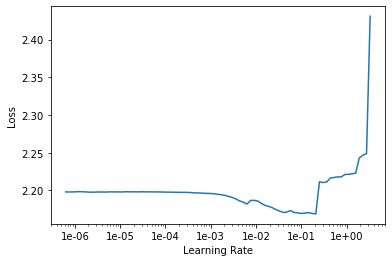

In [45]:
learner.recorder.plot()

In [46]:
lr = 3e-2

In [47]:
learner.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.944710,1.852119,0.266111,0.208160,00:55


In [49]:
learner.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.784453,1.858004,0.276759,0.247004,00:55
1,1.725242,1.672369,0.361574,0.355419,00:55
2,1.630085,1.571554,0.404444,0.396461,00:56
3,1.542328,1.540579,0.417593,0.410173,00:56
4,1.485502,1.525820,0.427037,0.418343,00:56


In [52]:
learner.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.493008,1.591586,0.386019,0.366314,00:55
1,1.489946,1.536099,0.424352,0.402070,00:56
2,1.411165,1.521672,0.424444,0.424385,00:56
3,1.347815,1.466573,0.455463,0.445172,00:56


In [54]:
learner.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.369448,1.485605,0.453426,0.442724,00:55
1,1.354966,1.513470,0.431574,0.408632,00:56
2,1.278857,1.451373,0.470648,0.456289,00:56
3,1.208977,1.436063,0.473519,0.466672,00:56


In [57]:
learner.fit_one_cycle(4, lr/10)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.169073,1.438517,0.476389,0.468149,00:55
1,1.165029,1.431691,0.475648,0.467860,00:56
2,1.150237,1.429555,0.478611,0.473944,00:56
3,1.140521,1.430279,0.476019,0.469734,00:56


In [58]:
learner.save('cnn_clas')
#learn.load('cnn_clas')

### Set up full-page classifiers

To handle the full page classification task, we need to create wrapper models that can process variable length bootleg scores.

In [59]:
class FullPageClassifier_cropped(nn.Module):
    def __init__(self, pretrainedModel):
        super(FullPageClassifier_cropped, self).__init__()
        self.model = pretrainedModel

    def forward(self, x):
        bs, c, h, len_padded = x.shape
        assert bs == 1 # must be 1, since each image will be cropped differently
        assert c == 1
        assert h == 62
        assert len_padded >= 3
        len_actual = torch.nonzero(x.sum(dim=2).squeeze() != 0)[-1,0]
        out = self.model(x[:,:,:,0:len_actual])
        return out

In [60]:
class FullPageClassifier_ensembled(nn.Module):
    def __init__(self, pretrainedModel, chunklen, hop = None):
        super(FullPageClassifier_ensembled, self).__init__()
        self.model = pretrainedModel
        self.chunklen = chunklen
        self.hop = chunklen//2 if hop is None else hop

    def forward(self, x):
        bs, c, h, len_padded = x.shape
        assert bs == 1 # must be 1, since each image will be cropped differently
        assert c == 1
        assert h == 62
        assert len_padded >= 3
        l = torch.nonzero(x.sum(dim=2).squeeze() != 0)[-1,0] + 1
        startIdxs = np.arange(0, max(l-self.chunklen+1,1), self.hop)
        assert len(startIdxs) > 0
        bs_new = len(startIdxs)
        x_crops = torch.zeros(bs_new, c, h, self.chunklen)
        for i, startIdx in enumerate(startIdxs):
            x_crops[i,:,:,:] = x[0,:,:,startIdx:startIdx+self.chunklen]
        x_crops = x_crops.cuda()
        out = self.model(x_crops).mean(dim=0, keepdims=True)
        return out

And here are some helper functions to evaluate these models on full page bootleg scores.

In [61]:
def calcPagePrior_from_piecedirs(piece_dir_list, composer2idx):
    targs = np.array([composer2idx[p.split('/')[-3]] for p in piece_dir_list]) # e.g. score_feat/Bach/00756/                   
    numClasses = len(composer2idx)
    counts = np.zeros(numClasses)
    for i in range(numClasses):
        counts[i] += np.sum(targs == i)
    counts = counts / np.sum(counts)
    return counts

In [62]:
def evaluate_cnn_fullpage(learner, priors):
    '''Calculate evaluation metrics for CNN model on full page classification task.'''

    # get predictions on full page bootleg scores                                                                              
    probs, y = learner.get_preds(ds_type=DatasetType.Valid)

    # ground truth labels                                                                                                      
    gt = torch.from_numpy(learner.data.valid_ds.y.items)

    # apply priors                                                                                                             
    priors = torch.from_numpy(priors.reshape((1,-1)))
    probs_with_priors = torch.mul(probs, priors)

    # calc accuracy                                                                                                            
    acc = accuracy(probs, gt).item()
    acc_with_prior = accuracy(probs_with_priors, gt).item()

    # calc macroF1                                                                                                             
    f1 = macroF1(probs, gt)
    f1_with_prior = macroF1(probs_with_priors, gt)

    return (acc, acc_with_prior), (f1, f1_with_prior)

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [63]:
bs=512
data_test = ImageDataBunch.from_folder(chunk_data_dir, valid='test', bs=bs)
getattr(data_test, 'train_dl').x.convert_mode = "L" # read images as grayscale
getattr(data_test, 'valid_dl').x.convert_mode = "L"

In [64]:
learner.validate(data_test.valid_dl, metrics=[accuracy, FBeta(average='macro', beta=1)])

[1.4572774, tensor(0.4730), tensor(0.4677)]

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.

In [65]:
bs = 1 # batch size must be 1 since each image is cropped differently                                                      
data_test = ImageDataBunch.from_folder(fullpage_data_dir, valid='test', bs=bs)
getattr(data_test, 'train_dl').x.convert_mode = "L" # read images as grayscale                                             
getattr(data_test, 'valid_dl').x.convert_mode = "L"

In [66]:
model_fullpage_cropped = FullPageClassifier_cropped(learner.model)

In [67]:
learner_single = Learner(data_test, model_fullpage_cropped)

In [68]:
priors = calcPagePrior_from_piecedirs(pieceDirs_train + pieceDirs_valid, composer2idx)

In [69]:
(acc, acc_with_prior), (f1, f1_with_prior) = evaluate_cnn_fullpage(learner_single, priors)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.6012269854545593, 0.6050613522529602),
 (0.5573552660788195, 0.5058155282241844))

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [70]:
model_fullpage_ensembled = FullPageClassifier_ensembled(learner.model, chunksz)

In [71]:
learner_ensembled = Learner(data_test, model_fullpage_ensembled)

In [72]:
(acc, acc_with_prior), (f1, f1_with_prior) = evaluate_cnn_fullpage(learner_ensembled, priors)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.5567484498023987, 0.5705521702766418),
 (0.518328159390815, 0.4784590229586475))

### Error Analysis

Investigate most commonly confused pairs at the fragment level.

In [73]:
interp = ClassificationInterpretation.from_learner(learner_single)

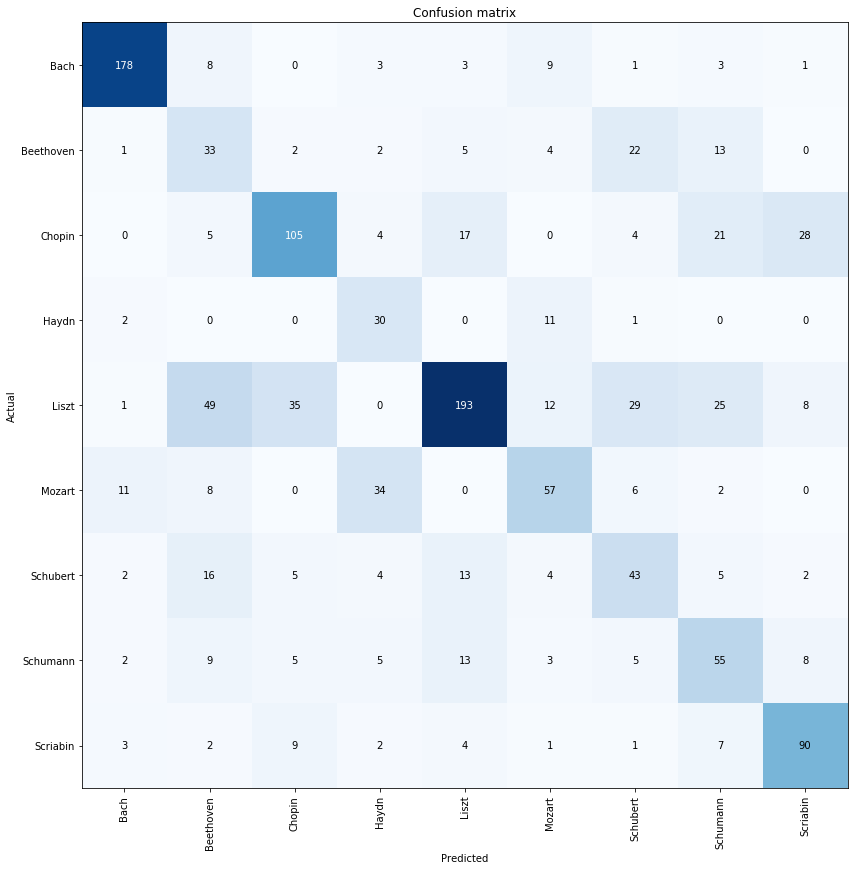

In [74]:
interp.plot_confusion_matrix(figsize=(12,12))